# Documentation  

Anaconda 2019.07 버전의 python 3.7.4 defalut 값으로 진행  
  
Python = 3.7.4  
Pandas = 0.25.1   
Numpy = 1.16.5  
urllib3 = 1.24.2  
BeautifulSoup = 4.8.0  
requests = 2.22.0   
selenium = 3.141.0  
pyautogui = 0.9.52  
pillow = 7.2.0

In [20]:
#import module

import pandas as pd
import numpy as np
import time
import re
import os
import datetime as dt

import urllib3
from bs4 import BeautifulSoup
import requests
import urllib.request

import selenium

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait

import warnings
warnings.filterwarnings(action='ignore')


### 다른 사이트의 경우 IT이외의 다른 분야의 기사가 많이 혼재하여 선제적으로 IT관련 뉴스가 가장 많은
### 네이버 뉴스 IT/과학 헤드라인
### ITWorld korea의 머신러닝, 클라우드, 빅데이터 파트
### ZDnet의 인공지능 파트에서 데이터를 추출할 예정입니다

#### 현재는 네이버 뉴스의 IT/과학 헤드라인을 먼저 실행중이며, 하나의 URL에서 전체 뉴스의 URL로 확장하는 작업중에 있습니다  
#### IT/과학 헤드라인의 헤드라인 더보기 전까지 기사의 제목과 URL을 추출후 DataFrame안에 저장하여 기록하고  
#### 이후 저장한 URL에 개별 접속하여 기사의 본문을 가져와서 저장하는 형식으로 진행하였습니다

In [21]:
news = 'https://news.naver.com/main/main.nhn?mode=LSD&mid=shm&sid1=105' ## IT/과학 헤드라인 뉴스  url

res = requests.get(news, headers={'User-Agent':'Chrome/85.0.4183.121'},verify = False) 
# requests이용하여 뉴스 주소 Load, 네이버 크롬 차단 방지 위해 chrome version을 입력하고 뉴스 주소를 설정
# SSL ERROR 방지를 위해 Verify False 설정
soup = BeautifulSoup(res.text, "html.parser") # html기준으로 parsing

title_list =[] # 제목을 저장하기 위한 list 생성
url_list = [] #URL을 저장하기 위한 list 생성

results = soup.select("#main_content a")  # 기사 제목과 URL이 모두 html main_content a에 저장되어 있어서 해당 부분을 select하여 추출


# 제목, 링크 출력 ---------------------------(2)
for result in results:
    if result.string == None: # 값이 존재하지 않을 경우 해당 루프 건너 뜀
        continue
    
    if result.attrs['href'] in ['#'] : # 헤드라인 더보기의 end code가 #이므로 #일 경우 loop문을 Break하여 종료함
        break
    
    if result.attrs['href'].startswith('http') == False : 
        # 해당 href에서 url 코드가 http로 시작하지 않을경우 url이 아니라고 판단하여 해당 부분 skip
        continue
    

    title_list.append(str.strip(result.string)) #기록된 기사 제목을 리스트에 추가
    url_list.append(result.attrs['href']) #기록된 기사 URL을 리스트에 추가


df = pd.DataFrame({'title': title_list,'url':url_list}) # 기사제목과, URL을 dataframe에 임시 저장
df['title'] = df.title.str.replace('\\',"") # 따옴표가  \' 형태로 기록되어 해당 \를 공란으로 대체
df.head(10)

,title,url
0,"아이폰12, 14일 새벽 공개…관전 포인트는",https://news.naver.com/main/read.nhn?mode=LSD&...
1,내일 새벽 '아이폰12' 공개…디자인·색상·가격 총정리,https://news.naver.com/main/read.nhn?mode=LSD&...
2,"아이폰12, 내일 새벽 공개…‘슈퍼 사이클’ 유발할까",https://news.naver.com/main/read.nhn?mode=LSD&...
3,이통사 '아이폰12' 출시 채비... '사전예약 알림' 개시,https://news.naver.com/main/read.nhn?mode=LSD&...
4,유전자가위로 바이오디젤 만드는 미생물 능력 ↑,https://news.naver.com/main/read.nhn?mode=LSD&...
5,버려지는 택배 박스로 디젤 연료 만든다,https://news.naver.com/main/read.nhn?mode=LSD&...
6,디지털뉴딜 2.2만여개 'AI 데이터 가공 일자리 정보' 한눈에,https://news.naver.com/main/read.nhn?mode=LSD&...
7,"과기정통부·NIA ""AI 데이터 다루는 기업들 정보, 한눈에 보세요""",https://news.naver.com/main/read.nhn?mode=LSD&...
8,"[TF현장] KT, 네이버·카카오와 겨룬다…웹툰 사업 강화 박차",https://news.naver.com/main/read.nhn?mode=LSD&...
9,KT가 웹소설 제작에 100억원 투자하는 이유는,https://news.naver.com/main/read.nhn?mode=LSD&...


#### 헤드라인 뉴스는 전날에 생성된 헤드라인 뉴스도 포함되어 있기 때문에 뉴스를 저장 후 
#### 전날의 기사와 비교하여 중복된 기사를 제거하는 작업이 필요하다

In [22]:
# 이전 뉴스 기사 제목 Load
save_news_title = pd.read_csv('C:/driver/save_news_title.csv',encoding='UTF-8')

In [23]:
before_list = []
for before_news in save_news_title.title :
    if len(save_news_title) >= 20 :
        save_news_title.drop([0,1,2,3,4],inplace=True).reset_index(drop=True)
        continue
    for row, now_news in enumerate(df.title) :
        if now_news in before_news :
            before_list.append(row)

            
if not before_list :
    df.drop(before_list,inplace=True)

In [24]:
# 데이터 저장
save_news_title = pd.concat([save_news_title,df]) # 이전 뉴스에 오늘자 뉴스 추가
save_news_title.to_csv('C:/driver/save_news_title.csv',encoding='UTF-8',index=False) # 추가한 데이터 저장

### 중복된 기사를 제거하기 위해 헤드라인 뉴스 밑에 있는 중복된 기사를 제거하는 작업이 필요하다

이를 위해 해당 중복된 뉴스의 tag를 찾아 제목을 기록하고 이와 똑같은 뉴스를 찾아 제거한다

In [25]:
# 중복된 기사 list 추출
duplicate_list = []
dup_title = soup.find_all("li",{"class":"cluster_item as_line"})
for dup in dup_title:
    text = dup.a.get_text()
    duplicate_list.append(text.replace('\\',""))
duplicate_list

["내일 새벽 '아이폰12' 공개…디자인·색상·가격 총정리",
 '아이폰12, 내일 새벽 공개…‘슈퍼 사이클’ 유발할까',
 "이통사 '아이폰12' 출시 채비... '사전예약 알림' 개시",
 '[핵잼 사이언스] 증강현실(AR) 고글 쓰고 훈련 받는 美 군견',
 "[핵잼 사이언스] 완벽 보존된 2000년 전 남성의 '뇌세포' 확인",
 "[핵잼 사이언스] 단거리 달리기 속도의 비밀 '큰 엉덩이 근육'에 있다",
 "[이슈IN] '20배 빠른 5G'는 공수표…비싼 요금제로 '호갱'만 늘어",
 "[이슈IN] 국위선양으로 입영연기? 변수는 '기준'",
 '[이슈IN] "만지고 싶어?"…게임 \'아이들프린세스\' 선정성 논란 휩싸여']

In [26]:
df

,title,url
0,"아이폰12, 14일 새벽 공개…관전 포인트는",https://news.naver.com/main/read.nhn?mode=LSD&...
1,내일 새벽 '아이폰12' 공개…디자인·색상·가격 총정리,https://news.naver.com/main/read.nhn?mode=LSD&...
2,"아이폰12, 내일 새벽 공개…‘슈퍼 사이클’ 유발할까",https://news.naver.com/main/read.nhn?mode=LSD&...
3,이통사 '아이폰12' 출시 채비... '사전예약 알림' 개시,https://news.naver.com/main/read.nhn?mode=LSD&...
4,유전자가위로 바이오디젤 만드는 미생물 능력 ↑,https://news.naver.com/main/read.nhn?mode=LSD&...
5,버려지는 택배 박스로 디젤 연료 만든다,https://news.naver.com/main/read.nhn?mode=LSD&...
6,디지털뉴딜 2.2만여개 'AI 데이터 가공 일자리 정보' 한눈에,https://news.naver.com/main/read.nhn?mode=LSD&...
7,"과기정통부·NIA ""AI 데이터 다루는 기업들 정보, 한눈에 보세요""",https://news.naver.com/main/read.nhn?mode=LSD&...
8,"[TF현장] KT, 네이버·카카오와 겨룬다…웹툰 사업 강화 박차",https://news.naver.com/main/read.nhn?mode=LSD&...
9,KT가 웹소설 제작에 100억원 투자하는 이유는,https://news.naver.com/main/read.nhn?mode=LSD&...


In [27]:
# 중복된 기사 제거
title_row = []
for row, title in enumerate(df['title']) :
    if title in duplicate_list :
        title_row.append(row)

df.drop(title_row,inplace=True)
df.drop([5,7,9,11],inplace=True)

#### 위에 기사 제목과 비교하면 중복된 기사인 1,2,3 번의 뉴스가 제거된 것을 볼 수 있다

하지만 5,7번 기사처럼 main topic으로 기록된 기사의 경우 중복제거가 되지 않았다.  
해당 기사 중복 제거가 필요하다(1,2,3,5,7기사가 계속 중복)

In [28]:
df

,title,url
0,"아이폰12, 14일 새벽 공개…관전 포인트는",https://news.naver.com/main/read.nhn?mode=LSD&...
4,유전자가위로 바이오디젤 만드는 미생물 능력 ↑,https://news.naver.com/main/read.nhn?mode=LSD&...
6,디지털뉴딜 2.2만여개 'AI 데이터 가공 일자리 정보' 한눈에,https://news.naver.com/main/read.nhn?mode=LSD&...
8,"[TF현장] KT, 네이버·카카오와 겨룬다…웹툰 사업 강화 박차",https://news.naver.com/main/read.nhn?mode=LSD&...
10,로봇이 스스로 학습해 임무까지 수행한다,https://news.naver.com/main/read.nhn?mode=LSD&...


In [67]:
df.url.tolist()

['https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002201756',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=003&aid=0010122959',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=629&aid=0000046478',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=584&aid=0000010902']

### 네이버 뉴스는 IT/과학이기 때문에 과학과 관련된 단어 리스트 추가를 통해
### 과학과 관련된 뉴스를 최대한 제거하는 작업이 필요하다고 판단

이를 위해 과학에 국한된 단어 리스트를 추가하여 기사 제목이나 본문에 해당 단어 빈도수가 높을 경우 제거

또한 연재중인 특정 카테고리 '[]' 로 되어있는 리스트도 추가함


### 또한 헤드라인 뉴스에서 전날의 중복된 기사의 경우 제거한 후 제공해야 함

중복 기사를 위해 전날의 기사 제목을 csv에 저장하고 기사가 30개 이상일 경우 앞의 row를 5개 제거하고 저장하는 형식으로 진행할 예정

In [29]:
df.reset_index(drop=True,inplace=True) # dataframe index 재설정

In [36]:
science_list = ['노벨','노벨화학상','화학','과학자','후쿠시마','세포','방사능','방사선','세포','암',
                '[이슈IN]','[슬기로운 소비생활]','[사이언스샷]','[핵잼 사이언스]','[사이언스카페]'
                '바이러스','미생물','가위', '세포의','코로나','코로나19','유전자','유전자가위로',
                'DNA','오염수','국감','세슘','원전','미세먼지'] # 10.12일자 과학 단어 list

In [37]:
science_drop = []
for row, science in enumerate(df.title) :
    count=0
    title_split = re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣| a-zA-Z0-9]", " ",science) # 특수문자 제거
    title_split = re.split(' ', title_split) # 기사 제목을 띄어쓰기 단위로 구분
    title_split = [ string for string in title_split if string != ''] #  리스트에 빈공간인 ''로 저장되는 list 삭제
    
    for k in science_list :
        if title_split.count(k)>=1 :
            count +=1
            if count>=2 :
                count=0 
                science_drop.append(row)
                break
science_drop
df.drop(science_drop,inplace=True)

In [38]:
df

,title,url
0,"아이폰12, 14일 새벽 공개…관전 포인트는",https://news.naver.com/main/read.nhn?mode=LSD&...
2,디지털뉴딜 2.2만여개 'AI 데이터 가공 일자리 정보' 한눈에,https://news.naver.com/main/read.nhn?mode=LSD&...
3,"[TF현장] KT, 네이버·카카오와 겨룬다…웹툰 사업 강화 박차",https://news.naver.com/main/read.nhn?mode=LSD&...
4,로봇이 스스로 학습해 임무까지 수행한다,https://news.naver.com/main/read.nhn?mode=LSD&...


샘플 코드로서 저장된 URL중 하나에 접속하여 해당 기사의 제목과 본문 추출

In [41]:
url ='https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=629&aid=0000045669'  ## 각 뉴스 URL 주소 입력
title_list2 =[] # 기사 제목 저장 LIST 생성
news_list2 = [] # 뉴스 본문 저장 LIST 생성


responce = requests.get(url, headers={'User-Agent':'Chrome/85.0.4183.121'},verify = False) ## 뉴스 URL 주소 접속
news = BeautifulSoup(responce.text,'html.parser') # html 태그 기준으로 parsing
content = news.select("#articleBodyContents") # 기사 본문 저장되어 있는 html주소 복사



test = content[0].find('img')['src']
test

'https://imgnews.pstatic.net/image/629/2020/10/07/202034151602051493_20201007153501116.jpg?type=w647'

In [356]:
os.getcwd ()

'C:\\Users\\ADMIN\\project'

In [354]:
urllib.request.urlretrieve(test)

('C:\\Users\\ADMIN\\AppData\\Local\\Temp\\tmp04mey0or',
 <http.client.HTTPMessage at 0x218e16d9e88>)

In [350]:
test2 = '<img src=' + test +'alt="" style="border: 0px; display: inline-block; margin-bottom: 8px; vertical-align: middle; max-width: 100%;">'
test2

'<img src=https://imgnews.pstatic.net/image/629/2020/10/07/202034151602051493_20201007153501116.jpg?type=w647alt="" style="border: 0px; display: inline-block; margin-bottom: 8px; vertical-align: middle; max-width: 100%;">'

In [43]:
url ='https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=629&aid=0000045669'  ## 각 뉴스 URL 주소 입력
title_list2 =[] # 기사 제목 저장 LIST 생성
news_list2 = [] # 뉴스 본문 저장 LIST 생성


responce = requests.get(url, headers={'User-Agent':'Chrome/85.0.4183.121'},verify = False) ## 뉴스 URL 주소 접속
news = BeautifulSoup(responce.text,'html.parser') # html 태그 기준으로 parsing
content = news.select("#articleBodyContents") # 기사 본문 저장되어 있는 html주소 복사


news_content = content[0]

for target in news_content.find_all('script'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()

for target in news_content.find_all('a'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()

for target in news_content.find_all('span'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()

for target in news_content.find_all('div'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()
    
for target in news_content.find_all('iframe'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()

    
for target in news_content.find_all('br'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.replace_with("\n")    

    
news_content



<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->



<strong>7일 국회 과방위 과기정통부 국정감사서 '구글 수수료 30%' 관련 정부 대책 마련 촉구</strong>

[더팩트│최수진 기자] 국회에서 구글의 수수료 30% 정책에 대한 우려의 목소리가 나왔다. 정부가 적극적으로 나서서 글로벌 IT 공룡의 갑질을 막아야 한다는 주장이다.

7일 국회 과학기술방송통신위원회(과방위)의 과기정통부 국정감사에서 한준호 더불어민주당 의원은 "세계에서 두 번째로 큰 인터넷 시장인 인도에서 150개 스타트업 기업들이 비공식적으로 연합해 구글의 인앱결제 정책을 2022년 4월까지 연기했다"며 "인도에서는 구글이 무릎을 꿇은 것이다. 구글플레이 마켓 규모로 보면 인도 시장보다 국내 시장이 크다. 우리도 정부 차원에서 스타트업들과 함께 인도 사례를 참고해서 구글과 협상해야 한다"고 말했다.

이어 "정부에서 믿음을 줘야 한다"며 "엔씨소프트 같은 경우도 왜 참고인 출석을 안 했겠냐. 구글의 눈치를 보는 것이다. 기업이 눈치를 보지 않도록 정부가 우리 스타트업과 기업들을 보살펴주고 방패가 될 필요가 있다"고 덧붙였다.

앞서 구글은 지난 9월 온라인 간담회를 열고, 내년부터 플레이스토어에 등록된 모든 앱 및 콘텐츠에 일괄적으로 30%의 수수료를 부과한다고 밝혔다. 이와 함께 인앱결제(IAP)도 강제한다. 신규 앱은 내년 1월 20일부터 적용되며, 기존 앱은 내년 10월부터 변경된다.

문제는 구글의 결정을 따르지 않는 업체가 플레이스토어에서 퇴출당할 가능성이 존재한다는 점이다. 이에 국감에서도 관련된 우려를 표명했다.



홍정민 더불어민주당 의원 역시 "보통 규제라고 하면 시장이나 정부를 보는 입장에 따라 찬반이 갈리는데 구글 사안에 대해서는 모두 한목소리를 내고 있다"며 "정부가 나서서 공정거래법, 전기통신사업법 등 적용해

전체 URL로 확장 중

In [132]:
'''
url_test =df['url'].tolist()  ## 각 뉴스 URL 주소 입력
news_list = [] # 뉴스 본문 저장 LIST 생성

for page in url_test :
    
    responce = requests.get(page, headers={'User-Agent':'Chrome/85.0.4183.121'},verify = False) ## 뉴스 URL 주소 접속
    news = BeautifulSoup(responce.text,'html.parser') # html 태그 기준으로 parsing
    content = news.select("#articleBodyContents") # 기사 본문 저장되어 있는 html주소 복사


    news_content = content[0]

    for target in news_content.find_all('script'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
        target.extract()

    for target in news_content.find_all('a'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
        target.extract()

    for target in news_content.find_all('span'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
        target.extract()

    for target in news_content.find_all('div'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
        target.extract()

    for target in news_content.find_all('iframe'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
        target.extract()


    for target in news_content.find_all('br'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
        target.replace_with("\n")    

    news_text = news_content.get_text()
    news_text = news_text.replace("\t", "").replace('\'','') # text로 전환하며 저장되는 기타 \t \'를 각각 빈칸으로 변환
    news_list.append(news_text)
    time.sleep(10)

final_title = df.title.tolist()
news_list

'''

5

In [138]:
final_title = df.title.tolist()
news_list

['\n\n\n\n\n1일 1회 이상 방송...14일까지 ‘브랜드 슈퍼데이’ 행사(지디넷코리아=백봉삼  기자)카카오커머스(대표 홍은택)가 12일 카카오쇼핑라이브를 정식 오픈하며, 국내 라이브 커머스 시장을 겨냥한 새로운 쇼핑 문화 창출에 나선다.\n\n카카오쇼핑라이브는 이번 정식 오픈을 계기로 방송 횟수 확대를 통한 다양한 브랜드의 라이브 커머스를 선보일 예정이다. 기존 모바일 쇼핑이 갖던 소통의 한계를 넘어 상품 및 브랜드에 대한 다각도 정보는 물론이고, 쌍방향 소통이 가능한 고객 중심 라이브 커머스로 거듭날 계획이다.\n\n우선 정식 오픈 후 현재 1주에 1~2회 진행했던 방송 횟수를 확대해 매일 1회 이상 라이브 커머스를 진행한다. 이를 위해 카카오커머스는 현재 카카오쇼핑라이브 전담팀 신설 및 자체 스튜디오 설립 등 전문 인프라 구축을 통해 차별화된 콘텐츠 기획/제작 역량을 마련했다.\n\n\n이처럼 제작된 방송은 카카오쇼핑라이브 톡채널 및 카카오 쇼핑하기, 카카오 선물하기를 통해서도 만나볼 수 있다. 다음엠탑 쇼핑탭, 카카오톡 샵탭에서도 라이브 방송이 노출돼 고객들이 다양한 채널을 통해 카카오쇼핑라이브를 시청할 수 있도록 접근성을 강화했다.\n\n또 정식 오픈 이후에는 다양한 전문가와 함께 하는 정규 프로그램을 신설해 고객이 구매에 필요한 상품 정보를 전문가와 실시간 소통할 수 있는 콘텐츠를 강화할 계획이다. 아울러 개개인이 원하는 브랜드 상품을 라이브로 만날 수 있도록 고객 맞춤형 시스템도 구축할 예정이다.\n\n더불어 점차 다양화되는 모바일 쇼핑에 대한 고객 니즈를 고려해 럭셔리 브랜드와의 협업을 강화해 보다 차별화된 상품을 고객에게 선보일 계획이다. 중소상공인을 위한 방송 창구도 마련해 제작 시스템을 마련하기 어려운 파트너들을 위한 도움도 지원한다.\n\n카카오쇼핑라이브는 이번 정식 오픈을 기념해 12일부터 14일까지 3일간 &apos;카카오커머스 브랜드 슈퍼데이&apos;를 선보인다. 카카오커머스 브랜드 슈퍼데이는 카카오커머스가 브랜드와 함께 기

셀레니움도 전체로 확장 작업 중

In [ ]:
path = "C:/driver/chromedriver.exe"    # 크롬드라이버 설치 경로 설정
set_id = open("C:/driver/set_id.txt", 'r').read() #id 입력
set_pwd = open("C:/driver/pwd.txt", 'r').read() # pwd 입력

In [253]:
'''
# Selenium Load
driver = webdriver.Chrome(path) # chrome driver load
# site login
driver.get('https://autoway.hyundai.net/') # 오토웨이 접속
time.sleep(3)

driver.find_element_by_xpath('//*[@id="form1"]/div[3]/div[2]/div[3]/div/div[3]').click() # autoway접속하여 로그인창의 부품 선택

driver.find_element_by_xpath('//*[@id="drpGroupCopList"]/option[2]').click() # 부품의 현대트랜시스 선택


log = driver.find_element_by_id("userID") # 오토웨이 id 입력 주소
log.send_keys(set_id) # id입력
time.sleep(2)
pwd = driver.find_element_by_id("password") # 오토웨이 비밀번호 입력 주소
pwd.send_keys(set_pwd) # pwd 입력
time.sleep(8)
driver.find_element_by_xpath('//*[@id="Login"]').click() # 로그인 버튼 클릭
time.sleep(10)

driver.get('https://autoway.hyundai.net/board/H104/Lists/H10400357/TileListView.aspx') # 현대트랜시스 I.C.U주소 입력하여 접속
time.sleep(8)

for news_title, news_text in zip(final_title, news_list) :


    driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_de894c14_b56d_4d4b_9c89_374a6c0455c1_Search_NewButton_New_ctl00_ctl59_g_de894c14_b56d_4d4b_9c89_374a6c0455c1_Search_NewButton"]').click()
    # I.C.U 내부의 작성 버튼 클릭
    time.sleep(10)

    icu_title = driver.find_element_by_id("Title_fa564e0f-0c70-4ab9-b863-0177e6ddd247_$TextField") # 제목란 클릭
    icu_title.send_keys(news_title) # 작성 제목에 기사 제목 입력
    time.sleep(5)


    # iframe 전환

    # 작성 게시글 내부의 inline frame(iframe) 2개의 web page가 삽입되어 있습니다.
    # 기사를 입력하기 위해서는 내부에 들어가서 작성해야 합니다.
    # 이를 위해 tag_name으로 iframe이 입력된 전체 리스트를 찾고 
    # 기사 제목을 입력할 수 있는 iframe[0] 내부의 두번째 iframe에 접속하여 기사 본문을 게시하는 코드를 작성하였습니다.

    iframes = driver.find_elements_by_tag_name('iframe') # 모든 iframe tage_name을 검색
    driver.switch_to.frame(iframes[0]) # 그 중 본문을 작성할 수 있는 첫번째 iframe 선택


    second_iframe = driver.find_elements_by_tag_name('iframe') # 본문에 접속하기 위해서는 iframe[0]내부의 iframe에 접속하여 작성해야됨
    # 이를 위해 2번째 iframe을 검색
    driver.switch_to.frame(second_iframe[0])  # 검색한 두 번째 iframe 접속
    icu_news = driver.find_element_by_id("dext_body") # 해당 iframe 내의 기사를 입력할 수 있는 id = dext_body 검색
    icu_news.send_keys(news_text) # 해당 부분에 기사 내용 입력


    driver.switch_to_default_content() # 해당 iframe에 벗어나 상위 웹페이지로 연결
    time.sleep(2)
    # 기사 최종 게시 클릭
    # driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl06_btnSave"]').click()

    #샘플 테스트로 목록 클릭하여 빠져나오는 코드
    driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl07_List_ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl07"]/span').click()
    time.sleep(3)
'''

'\n# Selenium Load\ndriver = webdriver.Chrome(path) # chrome driver load\n# site login\ndriver.get(\'https://autoway.hyundai.net/\') # 오토웨이 접속\ntime.sleep(3)\n\ndriver.find_element_by_xpath(\'//*[@id="form1"]/div[3]/div[2]/div[3]/div/div[3]\').click() # autoway접속하여 로그인창의 부품 선택\n\ndriver.find_element_by_xpath(\'//*[@id="drpGroupCopList"]/option[2]\').click() # 부품의 현대트랜시스 선택\n\n\nlog = driver.find_element_by_id("userID") # 오토웨이 id 입력 주소\nlog.send_keys(set_id) # id입력\ntime.sleep(2)\npwd = driver.find_element_by_id("password") # 오토웨이 비밀번호 입력 주소\npwd.send_keys(set_pwd) # pwd 입력\ntime.sleep(8)\ndriver.find_element_by_xpath(\'//*[@id="Login"]\').click() # 로그인 버튼 클릭\ntime.sleep(10)\n\ndriver.get(\'https://autoway.hyundai.net/board/H104/Lists/H10400357/TileListView.aspx\') # 현대트랜시스 I.C.U주소 입력하여 접속\ntime.sleep(8)\n\nfor news_title, news_text in zip(final_title, news_list) :\n\n\n    driver.find_element_by_xpath(\'//*[@id="ctl00_ctl59_g_de894c14_b56d_4d4b_9c89_374a6c0455c1_Search_NewButton_New_ct

샘플로 기사 제목 추출

In [45]:
title = news.select("#articleTitle")
title = title[0]
news_title = title.text

#### Autoway의 I.C.U에 기사를 붙여넣기 하기 위해 해당 내용을 Text로 전환해야 한다


In [44]:
news_text = news_content.get_text()
news_text = news_text.replace("\t", "").replace('\'','') # text로 전환하며 저장되는 기타 \t \'를 각각 빈칸으로 변환
news_text


'\n\n\n\n\n\n\n7일 국회 과방위 과기정통부 국정감사서 구글 수수료 30% 관련 정부 대책 마련 촉구\n\n[더팩트│최수진 기자] 국회에서 구글의 수수료 30% 정책에 대한 우려의 목소리가 나왔다. 정부가 적극적으로 나서서 글로벌 IT 공룡의 갑질을 막아야 한다는 주장이다.\n\n7일 국회 과학기술방송통신위원회(과방위)의 과기정통부 국정감사에서 한준호 더불어민주당 의원은 "세계에서 두 번째로 큰 인터넷 시장인 인도에서 150개 스타트업 기업들이 비공식적으로 연합해 구글의 인앱결제 정책을 2022년 4월까지 연기했다"며 "인도에서는 구글이 무릎을 꿇은 것이다. 구글플레이 마켓 규모로 보면 인도 시장보다 국내 시장이 크다. 우리도 정부 차원에서 스타트업들과 함께 인도 사례를 참고해서 구글과 협상해야 한다"고 말했다.\n\n이어 "정부에서 믿음을 줘야 한다"며 "엔씨소프트 같은 경우도 왜 참고인 출석을 안 했겠냐. 구글의 눈치를 보는 것이다. 기업이 눈치를 보지 않도록 정부가 우리 스타트업과 기업들을 보살펴주고 방패가 될 필요가 있다"고 덧붙였다.\n\n앞서 구글은 지난 9월 온라인 간담회를 열고, 내년부터 플레이스토어에 등록된 모든 앱 및 콘텐츠에 일괄적으로 30%의 수수료를 부과한다고 밝혔다. 이와 함께 인앱결제(IAP)도 강제한다. 신규 앱은 내년 1월 20일부터 적용되며, 기존 앱은 내년 10월부터 변경된다.\n\n문제는 구글의 결정을 따르지 않는 업체가 플레이스토어에서 퇴출당할 가능성이 존재한다는 점이다. 이에 국감에서도 관련된 우려를 표명했다.\n\n\n\n홍정민 더불어민주당 의원 역시 "보통 규제라고 하면 시장이나 정부를 보는 입장에 따라 찬반이 갈리는데 구글 사안에 대해서는 모두 한목소리를 내고 있다"며 "정부가 나서서 공정거래법, 전기통신사업법 등 적용해 규제해주길 바라고 있다. 정부가 개입을 안 하면 스타트업같이 취약한 경우는 앱 생태계 자체가 무너질 수 있는 중대한 사안"이라고 강조했다.\n\n이어 그는 "스타트업을 비롯해 인터넷 콘텐

### Selenium활용하여 Autoway에 자동 로그인

#### OTP 승인 없이 로그인 할 수 있는 ID를 받아 
#### chrome driver를 실행 후 해당 모든 기사의 제목과 url을 입력할 수 있도록 할 예정이다

In [56]:
from selenium.webdriver.common.keys import Keys



In [15]:
path = "C:/driver/chromedriver.exe"    # 크롬드라이버 설치 경로 설정

In [16]:
set_id = open("C:/driver/set_id.txt", 'r').read() #id 입력
set_pwd = open("C:/driver/pwd.txt", 'r').read() # pwd 입력

In [60]:
# Selenium Load
driver = webdriver.Chrome(path) # chrome driver load
# site login
driver.get('https://autoway.hyundai.net/') # 오토웨이 접속
time.sleep(3)

driver.find_element_by_xpath('//*[@id="form1"]/div[3]/div[2]/div[3]/div/div[3]').click() # autoway접속하여 로그인창의 부품 선택

driver.find_element_by_xpath('//*[@id="drpGroupCopList"]/option[2]').click() # 부품의 현대트랜시스 선택


log = driver.find_element_by_id("userID") # 오토웨이 id 입력 주소
log.send_keys(set_id) # id입력
time.sleep(2)
pwd = driver.find_element_by_id("password") # 오토웨이 비밀번호 입력 주소
pwd.send_keys(set_pwd) # pwd 입력
time.sleep(8)
driver.find_element_by_xpath('//*[@id="Login"]').click() # 로그인 버튼 클릭
time.sleep(10)

driver.get('https://autoway.hyundai.net/board/H104/Lists/H10400357/TileListView.aspx') # 현대트랜시스 I.C.U주소 입력하여 접속
time.sleep(8)
driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_de894c14_b56d_4d4b_9c89_374a6c0455c1_Search_NewButton_New_ctl00_ctl59_g_de894c14_b56d_4d4b_9c89_374a6c0455c1_Search_NewButton"]').click()
# I.C.U 내부의 작성 버튼 클릭
time.sleep(8)

icu_title = driver.find_element_by_id("Title_fa564e0f-0c70-4ab9-b863-0177e6ddd247_$TextField") # 제목란 클릭
icu_title.send_keys(news_title) # 작성 제목에 기사 제목 입력
time.sleep(5)


# iframe 전환

# 작성 게시글 내부의 inline frame(iframe) 2개의 web page가 삽입되어 있습니다.
# 기사를 입력하기 위해서는 내부에 들어가서 작성해야 합니다.
# 이를 위해 tag_name으로 iframe이 입력된 전체 리스트를 찾고 
# 기사 제목을 입력할 수 있는 iframe[0] 내부의 두번째 iframe에 접속하여 기사 본문을 게시하는 코드를 작성하였습니다.

iframes = driver.find_elements_by_tag_name('iframe') # 모든 iframe tage_name을 검색
driver.switch_to.frame(iframes[0]) # 그 중 본문을 작성할 수 있는 첫번째 iframe 선택


second_iframe = driver.find_elements_by_tag_name('iframe') # 본문에 접속하기 위해서는 iframe[0]내부의 iframe에 접속하여 작성해야됨
# 이를 위해 2번째 iframe을 검색
driver.switch_to.frame(second_iframe[0])  # 검색한 두 번째 iframe 접속
icu_news = driver.find_element_by_id("dext_body") # 해당 iframe 내의 기사를 입력할 수 있는 id = dext_body 검색
icu_news.send_keys(news_text) # 해당 부분에 기사 내용 입력

    
driver.switch_to_default_content() # 해당 iframe에 벗어나 상위 웹페이지로 연결

# 기사 최종 게시 클릭
# driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl06_btnSave"]').click()

#샘플 테스트로 목록 클릭하여 빠져나오는 코드
# driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl07_List_ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl07"]/span').click()



#### 샘플 테스트 결과 제목과 기사 본문 모두 작성이 완료되고 목록으로 빠져나오는 것을 확인할 수 있다.

이후 이미지 복사 후 이미지 저장까지 적용할 예정입니다.

# test

### ITWorld Korea 머신러닝, 클라우드, 빅데이터 파트 크롤링

### ITWorld 빅데이터 탭 크롤링

ITWorld의 빅데이터의 경우 매일 기사가 올라오지 않는다. 따라서 날짜를 기준으로 뉴스 기사를 판단한다.  
날짜의 경우 일주일이 지나지 않았을 때는 n일 전, 일주일 경과 후에는 yyyy.mm.dd와 같이 2가지 포맷을 따르기에 2가지 경우에 따라 데이터를 추출하는 작업이 필요하다


In [ ]:
itw_bigdata = 'http://www.itworld.co.kr/t/54649/%EB%B9%85%20%EB%8D%B0%EC%9D%B4%ED%84%B0' ## ITWorld 빅데이터 URL주소

res = requests.get(itw_bigdata, headers={'User-Agent':'Chrome/85.0.4183.121'},verify = False) 
# requests이용하여 뉴스 주소 Load, 네이버 크롬 차단 방지 위해 chrome version을 입력하고 뉴스 주소를 설정
# SSL ERROR 방지를 위해 Verify False 설정
soup = BeautifulSoup(res.text, "html.parser") # html기준으로 parsing

it_title_list =[] # 제목을 저장하기 위한 list 생성
it_url_list = [] #URL을 저장하기 위한 list 생성

results = soup.select('div > h4')
results

# 제목, 링크 출력 ---------------------------(2)
it_title = soup.select('div > h4 > a')
for i in it_title :
    it_title_list.append(str.strip(i.string)) #기록된 기사 제목을 리스트에 추가
    itworld_url = 'http://www.itworld.co.kr/'+ i.attrs['href']
    it_url_list.append(itworld_url)

    
# df = pd.DataFrame({'title': title_list,'url':url_list}) # 기사제목과, URL을 dataframe에 임시 저장
# df['title'] = df.title.str.replace('\\',"") # 따옴표가  \' 형태로 기록되어 해당 \를 공란으로 대체
# df.head(10)


# 날짜 추출

test2 = soup.find("div",{"class":"news_list_time default_small_font color_lightest_gray"})
test2 = test2.get_text()

# n일 전 일경우와 yyyy.mm.dd일 경우 구분

test2 = re.findall(r'\d+', test2)

In [268]:
test = soup.find("div",{"class":"of-h cb"})

In [270]:
test

<div class="of-h cb">
<div class="news_list_source color_lightest_gray font_12">
<a class="color_lightest_gray" href="/t/54649/빅 데이터">빅 데이터</a>
		          			          	/		          	<a class="color_lightest_gray" href="/t/39/애플리케이션">애플리케이션</a>
</div>
<div class="news_list_time default_small_font color_lightest_gray"><i class="icon-time news_list_time_icon color_light_gray font_12 default_small_font"></i> 4일 전</div>
</div>

In [285]:
test2 = soup.find("div",{"class":"news_list_time default_small_font color_lightest_gray"})

In [286]:
test2 = test2.get_text()
# test2 = str.strip(test2)
test2.endswith('전')

In [299]:
test2

'4일 전'

In [335]:
test2.endswith('일 전') 

True

In [312]:
date_list = []
if test2.endswith('일 전') ==True :
    test3 = re.findall(r'\d+', test2)
    test4 = datetime.now() - timedelta(days=int(test3[0]))
    date_list.append(test4)
elif bool(re.search(r'\d{3,4}.\d{1,2}.\d{2}',sample)) == True :
    test2.replace('.',"-")
    date_list.append(test2)
    
elif test2.endswith('분 전') ==True:
    test3 = re.findall(r'\d+', test2)
    test4 = datetime.now() - timedelta(minutes=int(test3[0]))

2020-10-09 08:23:06.463726


In [ ]:
start_date = datetime.now()
date_list = []
if test2.endswith('시간 전') ==True :
    test3 = re.findall(r'\d+', test2)
    test4 = datetime.now() - timedelta(hours=int(test3[0]))
    date_list.append(test4)
    
elif test2.endswith('분 전') ==True:
    test3 = re.findall(r'\d+', test2)
    test4 = datetime.now() - timedelta(minutes=int(test3[0]))
    date_list.append(test4)

elif bool(re.search(r'\d{3,4}.\d{1,2}.\d{2}',sample)) == True :
    test2.replace('.',"-")
    

In [307]:
test3 = re.findall(r'\d+', test2)
test3

['4']

In [311]:
timedelta(days=int(test3[0]))

datetime.timedelta(days=4)

In [306]:
from datetime import datetime, timedelta

datetime.now()

datetime.datetime(2020, 10, 13, 8, 20, 34, 60328)

In [ ]:
<img src="https://imgnews.pstatic.net/image/025/2020/10/12/0003042568_001_20201012181732187.jpg?type=w647" 
alt="" style="border: 0px; display: inline-block; margin-bottom: 8px; vertical-align: middle; max-width: 100%;">

In [ ]:
<img src="https://imgnews.pstatic.net/image/025/2020/10/12/0003042568_002_20201012181732215.jpg?type=w647" alt="" 
style="border: 0px; display: inline-block; margin-bottom: 8px; vertical-align: middle; max-width: 100%;">

In [ ]:
<img src="https://imgnews.pstatic.net/image/215/2020/10/13/A202010130072_1_20201013094854468.jpg?type=w647" 
alt="" style="border: 0px; display: inline-block; margin-bottom: 8px; vertical-align: middle; max-width: 100%;">

이미지 복사

In [183]:
url ='https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=092&aid=0002201756'  ## 각 뉴스 URL 주소 입력
title_list2 =[] # 기사 제목 저장 LIST 생성
news_list2 = [] # 뉴스 본문 저장 LIST 생성
image_list = []

responce = requests.get(url, headers={'User-Agent':'Chrome/85.0.4183.121'},verify = False) ## 뉴스 URL 주소 접속
news = BeautifulSoup(responce.text,'html.parser') # html 태그 기준으로 parsing
content = news.select("#articleBodyContents") # 기사 본문 저장되어 있는 html주소 복사


news_contentss = content[0]


for target in news_contentss.find_all('script'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()

for target in news_contentss.find_all('a'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()

# for target in news_contentss.find_all('span'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
#     image_list.append(target.find('img')['src'])
# #     target.extract()

for target in news_contentss.find_all('div'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()
    
for target in news_contentss.find_all('iframe'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.extract()

    
for target in news_contentss.find_all('br'): # 기사 본문에 추가로 저장되어 있는 각 class들 제거
    target.replace_with("\n")    

    

news_text = news_contentss.get_text()
news_contentss

<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->

<strong class="media_end_summary">4개 모델 같이 나올까…120Hz·라이다 스캐너·5G 여부도 주목</strong>(지디넷코리아=황정빈  기자)애플이 야심적으로 준비해 온 아이폰12가 마침내 베일을 벗는다. 아이폰12는 애플이 내놓는 첫 5G 스마트폰이 될 것으로 예상돼 스마트폰 시장에서 어떤 바람을 몰고 올지 관심이 쏠린다.

애플은 13일 오전 10시(현지시간, 한국시간 14일 오전 2시) 신제품 공개 행사를 개최한다. 코로나19 여파로 온라인으로 진행될 이번 행사에서 애플은 아이폰12 시리즈를 내놓을 것으로 예상된다.

이에 앞서 애플은 지난 9월 온라인 행사를 열고 ▲애플워치 시리즈6 ▲애플워치SE ▲아이패드8세대 ▲아이패드 에어 등을 공개했다.

<span style="position:relative;z-index:1;display:block;margin-top:24px;text-align:center; zoom:1;"><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/092/2020/10/13/0002201756_001_20201013140501531.jpg?type=w647"/></span><em style="display:block; padding-bottom:20px; margin:0px; color:#666; letter-spacing:-0.3px; line-height:19px; font-size:12px; font-family:gulim,Sans-serif;">아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)</em></span>

지금까지 전망을 종합하면 아이폰12 시리즈는 총 4개 모델으로 구성될

In [87]:
image_list

'https://imgnews.pstatic.net/image/092/2020/10/13/0002201756_001_20201013140501531.jpg?type=w647'

In [180]:
src_list = []
img_desc = []
em_list = []
image_list = []

news_contentss = content[0]
image_url = news_contentss.find_all('span')
for i in image_url:
    src_list.append(i.find('img')['src'])
    img_desc.append(i.get_text())
    

for v in src_list:
    if v not in image_list:
        image_list.append(v)
        
for k in img_desc:
    if not k :
        continue
        
    em_list.append(k)

In [181]:
em_list

['아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)',
 '애플은 지난 7일 글로벌 미디어들에 애플 이벤트 초청장을 발송했다. 애플은 이날 아이폰12를 공개할 전망이다.']

In [214]:
len(em_list)

2

In [118]:
image_list

['https://imgnews.pstatic.net/image/092/2020/10/13/0002201756_001_20201013140501531.jpg?type=w647',
 'https://imgnews.pstatic.net/image/092/2020/10/13/0002201756_002_20201013140501569.png?type=w647']

In [215]:
final_text_list = []
if len(em_list) != 0:
    for row,i in enumerate(em_list) :
#         print(sample)
        news_cut = news_text.find(i)
        print(int(news_cut),'\n')
        main_text = news_text[0:bb]
        either_text = news_text[bb:]
        print(either_text)
        if row == 0:
            if int(bb) >=20 :
                news_text = either_text
                final_text_list.append(main_text)
                continue
            else : 
                news_text = main_text
                final_text_list.append(main_text)
                continue
        news_text = main_text
        final_text_list.append(main_text)
        
        if row == len(em_list)-1 :
            final_text_list.append(either_text)

        

348 

아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)

지금까지 전망을 종합하면 아이폰12 시리즈는 총 4개 모델으로 구성될 것으로 예상된다. ▲5.4인치 아이폰12미니(가칭) ▲6.1인치 아이폰12 ▲6.1인치 아이폰12 프로(가칭) ▲6.7인치 아이폰12 프로맥스(가칭) 4가지 모델로 구성될 전망이다.

지난 해 나온 아이폰11와 달리 올해는 &apos;미니&apos; 모델이 추가될 것이 유력하다.

아이폰12 시리즈의 겉모양은 전작과 크게 달라지지는 않을 전망이다. 하지만 아이폰4와 비슷한 각진 디자인을 채택할 것으로 예상된다. 노치 크기가 줄어들 수 있다는 전망도 유력하게 제기되고 있다.

아이폰12 시리즈는 모두 OLED 디스플레이를 장착하고, A14 바이오닉 칩셋을 탑재할 것으로 예상된다. 하위모델인 아이폰12미니와 아이폰12는 후면에 듀얼 카메라를, 상위모델인 아이폰12프로와 아이폰12 프로맥스는 트리플 카메라를 탑재할 전망이다.

애플은 지난 7일 글로벌 미디어들에 애플 이벤트 초청장을 발송했다. 애플은 이날 아이폰12를 공개할 전망이다.
최상위 모델인 아이폰12 프로맥스에는 라이다(LiDAR) 스캐너가 탑재될 수 있다는 전망도 나온다. 라이다 스캐너는 빛이 물체에 닿았다가 반사돼 돌아오는 데 걸리는 시간을 측정해 거리를 파악하는 기술로, 증강 현실(AR)을 구현하는 데 사용된다. 라이다 스캐너는 아이패드 프로에 탑재된 바 있다.


120Hz 고주사율을 지원 여부도 관심사다. 그 동안 아이폰12 프로 맥스에 한해 120Hz 고주사율을 지원할 것이란 전망이 유력하게 제기됐다.

하지만 최근엔 내년에 출시될 아이폰에서 지원할 것이란 전망도 만만치 않다.

주사율은 1초에 얼마나 많은 장면을 보여주는지를 나타내는 수치다. 주사율이 높을수록 부드럽고 매끄러운 화면 전환을 느낄 수 있다. 그런만큼 사용자들의 만족도를 높이는 데는 중요한 역할을 한다.

실제로 삼성전자가 최근 조사한 갤럭시 스마트폰 중 가장 만족하는 디스플

In [217]:
for i in final_text_list:
    print(i,'\n\n\n')
    






4개 모델 같이 나올까…120Hz·라이다 스캐너·5G 여부도 주목(지디넷코리아=황정빈  기자)애플이 야심적으로 준비해 온 아이폰12가 마침내 베일을 벗는다. 아이폰12는 애플이 내놓는 첫 5G 스마트폰이 될 것으로 예상돼 스마트폰 시장에서 어떤 바람을 몰고 올지 관심이 쏠린다.

애플은 13일 오전 10시(현지시간, 한국시간 14일 오전 2시) 신제품 공개 행사를 개최한다. 코로나19 여파로 온라인으로 진행될 이번 행사에서 애플은 아이폰12 시리즈를 내놓을 것으로 예상된다.

이에 앞서 애플은 지난 9월 온라인 행사를 열고 ▲애플워치 시리즈6 ▲애플워치SE ▲아이패드8세대 ▲아이패드 에어 등을 공개했다.

 



아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)

지금까지 전망을 종합하면 아이폰12 시리즈는 총 4개 모델으로 구성될 것으로 예상된다. ▲5.4인치 아이폰12미니(가칭) ▲6.1인치 아이폰12 ▲6.1인치 아이폰12 프로(가칭) ▲6.7인치 아이폰12 프로맥스(가칭) 4가지 모델로 구성될 전망이다.

지난 해 나온 아이폰11와 달리 올해는 &apos;미니&apos; 모델이 추가될 것이 유력하다.

아이폰12 시리즈의 겉모양은 전작과 크게 달라지지는 않을 전망이다. 하지만 아이폰4와 비슷한 각진 디자인을 채택할 것으로 예상된다. 노치 크기가 줄어들 수 있다는 전망도 유력하게 제기되고 있다.

아이폰12 시리즈는 모두 OLED 디스플레이를 장착하고, A14 바이오닉 칩셋을 탑재할 것으로 예상된다. 하위모델인 아이폰12미니와 아이폰12는 후면에 듀얼 카메라를, 상위모델인 아이폰12프로와 아이폰12 프로맥스는 트리플 카메라를 탑재할 전망이다.

 



애플은 지난 7일 글로벌 미디어들에 애플 이벤트 초청장을 발송했다. 애플은 이날 아이폰12를 공개할 전망이다.
최상위 모델인 아이폰12 프로맥스에는 라이다(LiDAR) 스캐너가 탑재될 수 있다는 전망도 나온다. 라이다 스캐너는 빛이 물체에 닿았다가 반사돼 돌아오는 데 걸

In [202]:
em_list

['아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)',
 '애플은 지난 7일 글로벌 미디어들에 애플 이벤트 초청장을 발송했다. 애플은 이날 아이폰12를 공개할 전망이다.']

In [203]:
news_text
# print(main_text,'\n next \n',either_text)
# print(news_1)

'\n\n\n\n\n4개 모델 같이 나올까…120Hz·라이다 스캐너·5G 여부도 주목(지디넷코리아=황정빈  기자)애플이 야심적으로 준비해 온 아이폰12가 마침내 베일을 벗는다. 아이폰12는 애플이 내놓는 첫 5G 스마트폰이 될 것으로 예상돼 스마트폰 시장에서 어떤 바람을 몰고 올지 관심이 쏠린다.\n\n애플은 13일 오전 10시(현지시간, 한국시간 14일 오전 2시) 신제품 공개 행사를 개최한다. 코로나19 여파로 온라인으로 진행될 이번 행사에서 애플은 아이폰12 시리즈를 내놓을 것으로 예상된다.\n\n이에 앞서 애플은 지난 9월 온라인 행사를 열고 ▲애플워치 시리즈6 ▲애플워치SE ▲아이패드8세대 ▲아이패드 에어 등을 공개했다.\n\n아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)\n\n지금까지 전망을 종합하면 아이폰12 시리즈는 총 4개 모델으로 구성될 것으로 예상된다. ▲5.4인치 아이폰12미니(가칭) ▲6.1인치 아이폰12 ▲6.1인치 아이폰12 프로(가칭) ▲6.7인치 아이폰12 프로맥스(가칭) 4가지 모델로 구성될 전망이다.\n\n지난 해 나온 아이폰11와 달리 올해는 &apos;미니&apos; 모델이 추가될 것이 유력하다.\n\n아이폰12 시리즈의 겉모양은 전작과 크게 달라지지는 않을 전망이다. 하지만 아이폰4와 비슷한 각진 디자인을 채택할 것으로 예상된다. 노치 크기가 줄어들 수 있다는 전망도 유력하게 제기되고 있다.\n\n아이폰12 시리즈는 모두 OLED 디스플레이를 장착하고, A14 바이오닉 칩셋을 탑재할 것으로 예상된다. 하위모델인 아이폰12미니와 아이폰12는 후면에 듀얼 카메라를, 상위모델인 아이폰12프로와 아이폰12 프로맥스는 트리플 카메라를 탑재할 전망이다.\n\n애플은 지난 7일 글로벌 미디어들에 애플 이벤트 초청장을 발송했다. 애플은 이날 아이폰12를 공개할 전망이다.\n최상위 모델인 아이폰12 프로맥스에는 라이다(LiDAR) 스캐너가 탑재될 수 있다는 전망도 나온다. 라이다 스캐너는 빛이 물체에 닿았다가

In [177]:
print(news_either_0,'next \n')



지금까지 전망을 종합하면 아이폰12 시리즈는 총 4개 모델으로 구성될 것으로 예상된다. ▲5.4인치 아이폰12미니(가칭) ▲6.1인치 아이폰12 ▲6.1인치 아이폰12 프로(가칭) ▲6.7인치 아이폰12 프로맥스(가칭) 4가지 모델로 구성될 전망이다.

지난 해 나온 아이폰11와 달리 올해는 &apos;미니&apos; 모델이 추가될 것이 유력하다.

아이폰12 시리즈의 겉모양은 전작과 크게 달라지지는 않을 전망이다. 하지만 아이폰4와 비슷한 각진 디자인을 채택할 것으로 예상된다. 노치 크기가 줄어들 수 있다는 전망도 유력하게 제기되고 있다.

아이폰12 시리즈는 모두 OLED 디스플레이를 장착하고, A14 바이오닉 칩셋을 탑재할 것으로 예상된다. 하위모델인 아이폰12미니와 아이폰12는 후면에 듀얼 카메라를, 상위모델인 아이폰12프로와 아이폰12 프로맥스는 트리플 카메라를 탑재할 전망이다.

애플은 지난 7일 글로벌 미디어들에 애플 이벤트 초청장을 발송했다. 애플은 이날 아이폰12를 공개할 전망이다.
최상위 모델인 아이폰12 프로맥스에는 라이다(LiDAR) 스캐너가 탑재될 수 있다는 전망도 나온다. 라이다 스캐너는 빛이 물체에 닿았다가 반사돼 돌아오는 데 걸리는 시간을 측정해 거리를 파악하는 기술로, 증강 현실(AR)을 구현하는 데 사용된다. 라이다 스캐너는 아이패드 프로에 탑재된 바 있다.


120Hz 고주사율을 지원 여부도 관심사다. 그 동안 아이폰12 프로 맥스에 한해 120Hz 고주사율을 지원할 것이란 전망이 유력하게 제기됐다.

하지만 최근엔 내년에 출시될 아이폰에서 지원할 것이란 전망도 만만치 않다.

주사율은 1초에 얼마나 많은 장면을 보여주는지를 나타내는 수치다. 주사율이 높을수록 부드럽고 매끄러운 화면 전환을 느낄 수 있다. 그런만큼 사용자들의 만족도를 높이는 데는 중요한 역할을 한다.

실제로 삼성전자가 최근 조사한 갤럭시 스마트폰 중 가장 만족하는 디스플레이 기능에서는 120Hz 주사율이 압도적인 지지로 1위를 차지하기도 했다.

그런 

In [121]:
ee = news_contentss.get_text()

In [122]:
ee

'\n\n\n\n\n4개 모델 같이 나올까…120Hz·라이다 스캐너·5G 여부도 주목(지디넷코리아=황정빈  기자)애플이 야심적으로 준비해 온 아이폰12가 마침내 베일을 벗는다. 아이폰12는 애플이 내놓는 첫 5G 스마트폰이 될 것으로 예상돼 스마트폰 시장에서 어떤 바람을 몰고 올지 관심이 쏠린다.\n\n애플은 13일 오전 10시(현지시간, 한국시간 14일 오전 2시) 신제품 공개 행사를 개최한다. 코로나19 여파로 온라인으로 진행될 이번 행사에서 애플은 아이폰12 시리즈를 내놓을 것으로 예상된다.\n\n이에 앞서 애플은 지난 9월 온라인 행사를 열고 ▲애플워치 시리즈6 ▲애플워치SE ▲아이패드8세대 ▲아이패드 에어 등을 공개했다.\n\n아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)\n\n지금까지 전망을 종합하면 아이폰12 시리즈는 총 4개 모델으로 구성될 것으로 예상된다. ▲5.4인치 아이폰12미니(가칭) ▲6.1인치 아이폰12 ▲6.1인치 아이폰12 프로(가칭) ▲6.7인치 아이폰12 프로맥스(가칭) 4가지 모델로 구성될 전망이다.\n\n지난 해 나온 아이폰11와 달리 올해는 &apos;미니&apos; 모델이 추가될 것이 유력하다.\n\n아이폰12 시리즈의 겉모양은 전작과 크게 달라지지는 않을 전망이다. 하지만 아이폰4와 비슷한 각진 디자인을 채택할 것으로 예상된다. 노치 크기가 줄어들 수 있다는 전망도 유력하게 제기되고 있다.\n\n아이폰12 시리즈는 모두 OLED 디스플레이를 장착하고, A14 바이오닉 칩셋을 탑재할 것으로 예상된다. 하위모델인 아이폰12미니와 아이폰12는 후면에 듀얼 카메라를, 상위모델인 아이폰12프로와 아이폰12 프로맥스는 트리플 카메라를 탑재할 전망이다.\n\n애플은 지난 7일 글로벌 미디어들에 애플 이벤트 초청장을 발송했다. 애플은 이날 아이폰12를 공개할 전망이다.\n최상위 모델인 아이폰12 프로맥스에는 라이다(LiDAR) 스캐너가 탑재될 수 있다는 전망도 나온다. 라이다 스캐너는 빛이 물체에 닿았다가

In [79]:
aa

[<span style="position:relative;z-index:1;display:block;margin-top:24px;text-align:center; zoom:1;"><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/092/2020/10/13/0002201756_001_20201013140501531.jpg?type=w647"/></span><em style="display:block; padding-bottom:20px; margin:0px; color:#666; letter-spacing:-0.3px; line-height:19px; font-size:12px; font-family:gulim,Sans-serif;">아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)</em></span>,
 <span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/092/2020/10/13/0002201756_001_20201013140501531.jpg?type=w647"/></span>,
 <span style="position:relative;z-index:1;display:block;margin-top:24px;text-align:center; zoom:1;"><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/092/2020/10/13/0002201756_002_20201013140501569.png?type=w647"/></span><em style="display:block; padding-bottom:20px; margin:0px; color:#666; letter-spacing:-0.3px; line-height:19px; font-size:12px; font-

In [ ]:
aa

In [69]:
ee = news_contentss.get_text()

'\n\n\n\n\n4개 모델 같이 나올까…120Hz·라이다 스캐너·5G 여부도 주목(지디넷코리아=황정빈  기자)애플이 야심적으로 준비해 온 아이폰12가 마침내 베일을 벗는다. 아이폰12는 애플이 내놓는 첫 5G 스마트폰이 될 것으로 예상돼 스마트폰 시장에서 어떤 바람을 몰고 올지 관심이 쏠린다.\n\n애플은 13일 오전 10시(현지시간, 한국시간 14일 오전 2시) 신제품 공개 행사를 개최한다. 코로나19 여파로 온라인으로 진행될 이번 행사에서 애플은 아이폰12 시리즈를 내놓을 것으로 예상된다.\n\n이에 앞서 애플은 지난 9월 온라인 행사를 열고 ▲애플워치 시리즈6 ▲애플워치SE ▲아이패드8세대 ▲아이패드 에어 등을 공개했다.\n\n아이폰12 시리즈 렌더링 이미지.(사진=EVERYTHINGAPPLEPRO)\n\n지금까지 전망을 종합하면 아이폰12 시리즈는 총 4개 모델으로 구성될 것으로 예상된다. ▲5.4인치 아이폰12미니(가칭) ▲6.1인치 아이폰12 ▲6.1인치 아이폰12 프로(가칭) ▲6.7인치 아이폰12 프로맥스(가칭) 4가지 모델로 구성될 전망이다.\n\n지난 해 나온 아이폰11와 달리 올해는 &apos;미니&apos; 모델이 추가될 것이 유력하다.\n\n아이폰12 시리즈의 겉모양은 전작과 크게 달라지지는 않을 전망이다. 하지만 아이폰4와 비슷한 각진 디자인을 채택할 것으로 예상된다. 노치 크기가 줄어들 수 있다는 전망도 유력하게 제기되고 있다.\n\n아이폰12 시리즈는 모두 OLED 디스플레이를 장착하고, A14 바이오닉 칩셋을 탑재할 것으로 예상된다. 하위모델인 아이폰12미니와 아이폰12는 후면에 듀얼 카메라를, 상위모델인 아이폰12프로와 아이폰12 프로맥스는 트리플 카메라를 탑재할 전망이다.\n\n애플은 지난 7일 글로벌 미디어들에 애플 이벤트 초청장을 발송했다. 애플은 이날 아이폰12를 공개할 전망이다.\n최상위 모델인 아이폰12 프로맥스에는 라이다(LiDAR) 스캐너가 탑재될 수 있다는 전망도 나온다. 라이다 스캐너는 빛이 물체에 닿았다가

In [63]:
# Selenium Load
driver = webdriver.Chrome(path) # chrome driver load
# site login
driver.get('https://autoway.hyundai.net/') # 오토웨이 접속
time.sleep(3)

driver.find_element_by_xpath('//*[@id="form1"]/div[3]/div[2]/div[3]/div/div[3]').click() # autoway접속하여 로그인창의 부품 선택

driver.find_element_by_xpath('//*[@id="drpGroupCopList"]/option[2]').click() # 부품의 현대트랜시스 선택


log = driver.find_element_by_id("userID") # 오토웨이 id 입력 주소
log.send_keys(set_id) # id입력
time.sleep(2)
pwd = driver.find_element_by_id("password") # 오토웨이 비밀번호 입력 주소
pwd.send_keys(set_pwd) # pwd 입력
time.sleep(8)
driver.find_element_by_xpath('//*[@id="Login"]').click() # 로그인 버튼 클릭
time.sleep(10)

driver.get('https://autoway.hyundai.net/board/H104/Lists/H10400357/TileListView.aspx') # 현대트랜시스 I.C.U주소 입력하여 접속
time.sleep(8)
driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_de894c14_b56d_4d4b_9c89_374a6c0455c1_Search_NewButton_New_ctl00_ctl59_g_de894c14_b56d_4d4b_9c89_374a6c0455c1_Search_NewButton"]').click()
# I.C.U 내부의 작성 버튼 클릭
time.sleep(8)

icu_title = driver.find_element_by_id("Title_fa564e0f-0c70-4ab9-b863-0177e6ddd247_$TextField") # 제목란 클릭
icu_title.send_keys(news_title) # 작성 제목에 기사 제목 입력
time.sleep(5)


# iframe 전환

# 작성 게시글 내부의 inline frame(iframe) 2개의 web page가 삽입되어 있습니다.
# 기사를 입력하기 위해서는 내부에 들어가서 작성해야 합니다.
# 이를 위해 tag_name으로 iframe이 입력된 전체 리스트를 찾고 
# 기사 제목을 입력할 수 있는 iframe[0] 내부의 두번째 iframe에 접속하여 기사 본문을 게시하는 코드를 작성하였습니다.

iframes = driver.find_elements_by_tag_name('iframe') # 모든 iframe tage_name을 검색
driver.switch_to.frame(iframes[0]) # 그 중 본문을 작성할 수 있는 첫번째 iframe 선택


second_iframe = driver.find_elements_by_tag_name('iframe') # 본문에 접속하기 위해서는 iframe[0]내부의 iframe에 접속하여 작성해야됨
# 이를 위해 2번째 iframe을 검색
driver.switch_to.frame(second_iframe[0])  # 검색한 두 번째 iframe 접속
icu_news = driver.find_element_by_id("dext_body") # 해당 iframe 내의 기사를 입력할 수 있는 id = dext_body 검색

# icu_news.send_keys(Keys.CONTROL,'v')

# driver.switch_to_default_content() 
# driver.find_element_by_xpath('//*[@id="span_insert_image"]').click()


# iframes = driver.find_elements_by_tag_name('iframe') # 모든 iframe tage_name을 검색
# driver.switch_to.frame(iframes[0]) # 그 중 본문을 작성할 수 있는 첫번째 iframe 선택


# second_iframe = driver.find_elements_by_tag_name('iframe') # 본문에 접속하기 위해서는 iframe[0]내부의 iframe에 접속하여 작성해야됨
# # 이를 위해 2번째 iframe을 검색
# driver.switch_to.frame(second_iframe[0])  # 검색한 두 번째 iframe 접속
# icu_news = driver.find_element_by_id("dext_body")

icu_news.send_keys(news_contentss) # 해당 부분에 기사 내용 입력

    
driver.switch_to_default_content() # 해당 iframe에 벗어나 상위 웹페이지로 연결

# 기사 최종 게시 클릭
# driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl06_btnSave"]').click()

#샘플 테스트로 목록 클릭하여 빠져나오는 코드
# driver.find_element_by_xpath('//*[@id="ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl07_List_ctl00_ctl59_g_0005fe00_cee6_4765_9070_f77f554d027e_ctl00_ctl07"]/span').click()


KeyError: 0

In [5]:
url ='https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=105&oid=629&aid=0000045669'  ## 각 뉴스 URL 주소 입력
title_list2 =[] # 기사 제목 저장 LIST 생성
news_list2 = [] # 뉴스 본문 저장 LIST 생성


responce = requests.get(url, headers={'User-Agent':'Chrome/85.0.4183.121'},verify = False) ## 뉴스 URL 주소 접속
news = BeautifulSoup(responce.text,'html.parser') # html 태그 기준으로 parsing
content = news.select("#articleBodyContents") # 기사 본문 저장되어 있는 html주소 복사



test = content[0].find('img')['src']
test

'https://imgnews.pstatic.net/image/629/2020/10/07/202034151602051493_20201007153501116.jpg?type=w647'

In [6]:
img = urllib.request.urlretrieve(test,'test.jpg')

In [7]:
from PIL import Image
img = Image.open('test.jpg')

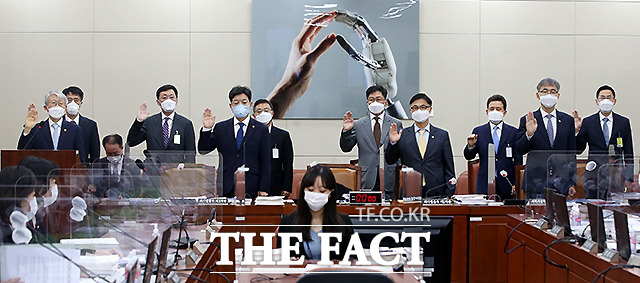

In [8]:
img

In [12]:
import pyautogui as P
import win32clipboard
from io import BytesIO


In [ ]:
def send_to_clipboard(clip_type, data):
    win32clipboard.OpenClipboard()
    win32clipboard.EmptyClipboard()
    win32clipboard.SetClipboardData(clip_type, data)
    win32clipboard.CloseClipboard()


In [58]:
output = BytesIO()
img.convert("RGB").save(output, "BMP")
data = output.getvalue()[14:]
output.close()

send_to_clipboard(win32clipboard.CF_DIB, data)

In [50]:
from PIL import ImageGrab # windows only 
im = ImageGrab.grabclipboard()


In [51]:
im

In [ ]:
//*[@id="span_insert_image"]